# Reuters 딥러닝 모델

ReLU와는 다른 활성화함수를 사용해보고, BatchNormalization과 Dropout을 적용해 본다. ModelCheckpoint와 EarlyStopping 콜백 함수도 적용한다.

## 데이터 로드 및 전처리

reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리한다. 
데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용하고, 이때 파라메터 조정을 통해 단어의 개수는 10000개로 제한한다(num_words=10000).
데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용하며 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [2]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(full_train_data, full_train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data, val_data, train_labels, val_labels = train_test_split(full_train_data, 
                                                                  full_train_labels,
                                                                  test_size=0.25,
                                                                  random_state=123)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행한다.
레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환한다.

In [3]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1
  return results
x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

## 모델 구성 및 컴파일

BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성한다.

In [4]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(10000, )))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 모델 학습

ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행한다.

In [6]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('keras_reuters_model.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10, monitor='val_loss',
                                            restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/100
211/211 [==============================] - 3s 7ms/step - loss: 1.9558 - accuracy: 0.5588 - val_loss: 1.5676 - val_accuracy: 0.6990
Epoch 2/100
211/211 [==============================] - 1s 5ms/step - loss: 1.2307 - accuracy: 0.7041 - val_loss: 1.1556 - val_accuracy: 0.7542
Epoch 3/100
211/211 [==============================] - 1s 5ms/step - loss: 1.0064 - accuracy: 0.7611 - val_loss: 1.0702 - val_accuracy: 0.7725
Epoch 4/100
211/211 [==============================] - 1s 5ms/step - loss: 0.8305 - accuracy: 0.8026 - val_loss: 1.0301 - val_accuracy: 0.7805
Epoch 5/100
211/211 [==============================] - 1s 5ms/step - loss: 0.7090 - accuracy: 0.8257 - val_loss: 1.0123 - val_accuracy: 0.7841
Epoch 6/100
211/211 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.8515 - val_loss: 0.9886 - val_accuracy: 0.7907
Epoch 7/100
211/211 [==============================] - 1s 5ms/step - loss: 0.5377 - accuracy: 0.8624 - val_loss: 1.0068 - val_accuracy: 0.7925

학습 히스토리의 loss, val_loss, accuracy, val_accuracy를 차트로 시각화한다.

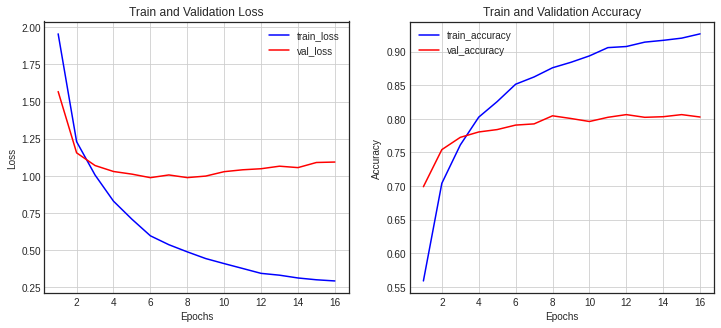

In [7]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가 및 예측

테스트 데이터셋을 이용해 모델을 평가한다.

In [8]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 0.9823 - accuracy: 0.7890


[0.9822595715522766, 0.7889581322669983]